# 데이터 전처리

In [1]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import konlpy
import gensim
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]
# 여러 개의 문장을 숫자 텐서로 변환

In [5]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_senteces]
# 여러 개의 숫자 벡터로 encode 된 문장들을 원래 문장으로 복원

In [6]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균:  15.96940191154864
문장길이 최대:  116
문장길이 표준편차:  12.843571191092
pad_sequences maxlen:  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


X, y 데이터 준비

In [7]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [8]:
vocab_size = 10000
word_vector_dim = 16

X_val = X_train[:10000]
y_val = y_train[:10000]

partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

# Model: RNN

In [9]:
rnn = tf.keras.Sequential()
rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
rnn.add(tf.keras.layers.LSTM(8))
rnn.add(tf.keras.layers.Dense(8, activation = 'relu'))
rnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
rnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs= epochs,
                    batch_size= 256,
                    validation_data= (X_val, y_val),
                    verbose= 1)

Epoch 1/20
532/532 [==============================] - 6s 6ms/step - loss: 0.4848 - accuracy: 0.7825 - val_loss: 0.3543 - val_accuracy: 0.8475
Epoch 2/20
532/532 [==============================] - 3s 5ms/step - loss: 0.3333 - accuracy: 0.8589 - val_loss: 0.3327 - val_accuracy: 0.8546
Epoch 3/20
532/532 [==============================] - 3s 5ms/step - loss: 0.3094 - accuracy: 0.8707 - val_loss: 0.3331 - val_accuracy: 0.8578
Epoch 4/20
532/532 [==============================] - 3s 5ms/step - loss: 0.2940 - accuracy: 0.8773 - val_loss: 0.3335 - val_accuracy: 0.8574
Epoch 5/20
532/532 [==============================] - 3s 5ms/step - loss: 0.2800 - accuracy: 0.8836 - val_loss: 0.3400 - val_accuracy: 0.8557
Epoch 6/20
532/532 [==============================] - 3s 5ms/step - loss: 0.2651 - accuracy: 0.8916 - val_loss: 0.3415 - val_accuracy: 0.8544
Epoch 7/20
532/532 [==============================] - 3s 5ms/step - loss: 0.2523 - accuracy: 0.8970 - val_loss: 0.3514 - val_accuracy: 0.8554
Epoch 

In [11]:
results = rnn.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.5464 - accuracy: 0.8397
[0.5463528633117676, 0.8396565914154053]


Visualization

In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


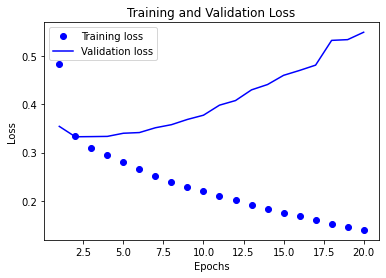

In [13]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

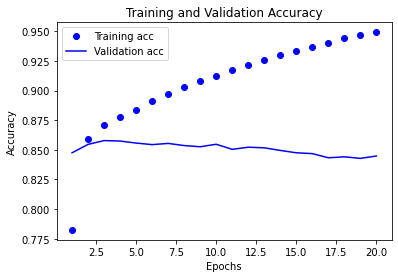

In [14]:
plt.clf()

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Embedding

In [15]:
embedding_rnn = rnn.layers[0]
weights = embedding_rnn.get_weights()[0]

In [16]:
word2vec_file_path =os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.08559562,  0.00067657,  0.07745751, -0.21671969, -0.05786731,
       -0.25272915,  0.20733353,  0.32653433, -0.03009479, -0.24298942,
        0.09835344, -0.50440717,  0.10951374, -0.08354977,  0.05496983,
       -0.33397353], dtype=float32)

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word('love')

[('덴젤워싱턴', 0.9956846833229065),
 ('황홀', 0.9924342632293701),
 ('조음', 0.9919096827507019),
 ('뜻깊', 0.9909749031066895),
 ('애요', 0.9909537434577942),
 ('스며드', 0.9902861714363098),
 ('입가', 0.9900915026664734),
 ('흠뻑', 0.9895188808441162),
 ('아려', 0.9893889427185059),
 ('봣습니다', 0.9893007278442383)]

한국어 Word2Vec

In [19]:
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [20]:
vocab_size = 10000    
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [21]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer = Constant(embedding_matrix), 
                                    input_length = maxlen, 
                                    trainable = True))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs= epochs,
                    batch_size= 256,
                    validation_data= (X_val, y_val),
                    verbose= 1)

Epoch 1/20
532/532 [==============================] - 4s 5ms/step - loss: 0.5659 - accuracy: 0.6824 - val_loss: 0.4473 - val_accuracy: 0.7963
Epoch 2/20
532/532 [==============================] - 2s 5ms/step - loss: 0.4056 - accuracy: 0.8181 - val_loss: 0.3880 - val_accuracy: 0.8261
Epoch 3/20
532/532 [==============================] - 2s 5ms/step - loss: 0.3507 - accuracy: 0.8476 - val_loss: 0.3693 - val_accuracy: 0.8354
Epoch 4/20
532/532 [==============================] - 2s 5ms/step - loss: 0.3195 - accuracy: 0.8640 - val_loss: 0.3580 - val_accuracy: 0.8422
Epoch 5/20
532/532 [==============================] - 2s 5ms/step - loss: 0.2970 - accuracy: 0.8762 - val_loss: 0.3514 - val_accuracy: 0.8463
Epoch 6/20
532/532 [==============================] - 2s 4ms/step - loss: 0.2790 - accuracy: 0.8848 - val_loss: 0.3494 - val_accuracy: 0.8500
Epoch 7/20
532/532 [==============================] - 2s 4ms/step - loss: 0.2635 - accuracy: 0.8924 - val_loss: 0.3514 - val_accuracy: 0.8530
Epoch 

In [23]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.5730 - accuracy: 0.8329
[0.5730077624320984, 0.832902729511261]


# Model: CNN

In [24]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
cnn.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling1D(5))
cnn.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
cnn.add(tf.keras.layers.GlobalMaxPooling1D())
cnn.add(tf.keras.layers.Dense(8, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [25]:
cnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs= epochs,
                    batch_size= 256,
                    validation_data= (X_val, y_val),
                    verbose= 1)

Epoch 1/20
532/532 [==============================] - 3s 5ms/step - loss: 0.4000 - accuracy: 0.8128 - val_loss: 0.3310 - val_accuracy: 0.8545
Epoch 2/20
532/532 [==============================] - 2s 4ms/step - loss: 0.2745 - accuracy: 0.8857 - val_loss: 0.3238 - val_accuracy: 0.8614
Epoch 3/20
532/532 [==============================] - 2s 5ms/step - loss: 0.1910 - accuracy: 0.9265 - val_loss: 0.3743 - val_accuracy: 0.8547
Epoch 4/20
532/532 [==============================] - 2s 4ms/step - loss: 0.1158 - accuracy: 0.9592 - val_loss: 0.4484 - val_accuracy: 0.8472
Epoch 5/20
532/532 [==============================] - 2s 4ms/step - loss: 0.0732 - accuracy: 0.9756 - val_loss: 0.5439 - val_accuracy: 0.8431
Epoch 6/20
532/532 [==============================] - 2s 4ms/step - loss: 0.0527 - accuracy: 0.9826 - val_loss: 0.6246 - val_accuracy: 0.8403
Epoch 7/20
532/532 [==============================] - 2s 5ms/step - loss: 0.0425 - accuracy: 0.9861 - val_loss: 0.6801 - val_accuracy: 0.8430
Epoch 

In [26]:
results = cnn.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 1.1661 - accuracy: 0.8297
[1.1660645008087158, 0.8297088742256165]


Visualization

In [27]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


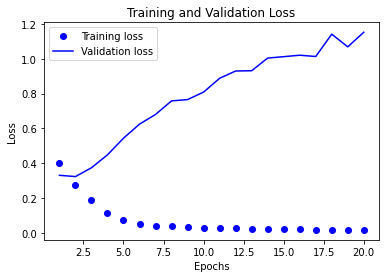

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

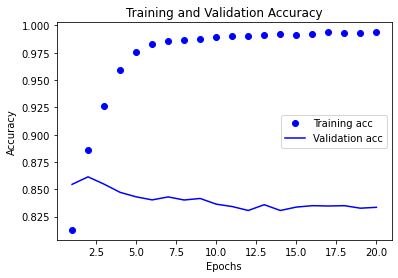

In [29]:
plt.clf()

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Embedding

In [30]:
embedding_cnn = cnn.layers[0]
weights = embedding_cnn.get_weights()[0]

In [31]:
word2vec_file_path =os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-1.07075907e-01,  8.55837017e-03, -6.57212511e-02,  1.44962713e-01,
        2.61581801e-02, -1.30292803e-01, -1.84644207e-01, -1.02757895e-02,
        4.65097018e-02, -7.96555877e-02, -2.44447365e-01,  2.95203328e-01,
        2.18771040e-01,  9.44310217e-04, -1.00030944e-01,  5.44784442e-02,
        1.69689566e-01, -2.08537325e-01,  4.15393263e-02, -2.41145983e-01,
        1.21776149e-01,  1.30095975e-02,  2.94518545e-02, -3.22220385e-01,
        1.80398524e-01, -1.80501528e-02, -4.87469556e-03,  1.74697489e-01,
        9.02976282e-03, -1.16273798e-01,  7.37747923e-02, -1.82483763e-01,
        9.02751535e-02, -1.01213455e-01,  1.20399315e-02, -3.03892400e-02,
        1.04421988e-01,  1.39918393e-02, -5.18741310e-02,  1.02240346e-01,
       -5.98986149e-02, -3.81109007e-02,  2.23244786e-01,  1.87385031e-05,
       -3.09748501e-02, -3.23720068e-01,  1.45075303e-02,  1.18393771e-01,
        2.53711730e-01, -7.37274764e-03, -1.14093743e-01, -1.71013847e-01,
        2.02154070e-01,  

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word('love')

[('고마워요', 0.8968068957328796),
 ('습니당', 0.8751513957977295),
 ('새록새록', 0.8725975751876831),
 ('슬퍼요', 0.8672952055931091),
 ('we', 0.8613718748092651),
 ('♥♥', 0.8603352904319763),
 ('스며드', 0.8551819324493408),
 ('조음', 0.8515118956565857),
 ('life', 0.8378891944885254),
 ('밋기', 0.8347744941711426)]

한국어 Word2Vec

In [34]:
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [35]:
vocab_size = 10000    
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [36]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer = Constant(embedding_matrix), 
                                    input_length = maxlen, 
                                    trainable = True))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [37]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs= epochs,
                    batch_size= 256,
                    validation_data= (X_val, y_val),
                    verbose= 1)

Epoch 1/20
532/532 [==============================] - 3s 5ms/step - loss: 0.5558 - accuracy: 0.6994 - val_loss: 0.4441 - val_accuracy: 0.7949
Epoch 2/20
532/532 [==============================] - 2s 4ms/step - loss: 0.4033 - accuracy: 0.8189 - val_loss: 0.3807 - val_accuracy: 0.8324
Epoch 3/20
532/532 [==============================] - 2s 4ms/step - loss: 0.3479 - accuracy: 0.8486 - val_loss: 0.3556 - val_accuracy: 0.8413
Epoch 4/20
532/532 [==============================] - 2s 5ms/step - loss: 0.3163 - accuracy: 0.8649 - val_loss: 0.3464 - val_accuracy: 0.8490
Epoch 5/20
532/532 [==============================] - 2s 4ms/step - loss: 0.2954 - accuracy: 0.8766 - val_loss: 0.3486 - val_accuracy: 0.8501
Epoch 6/20
532/532 [==============================] - 2s 4ms/step - loss: 0.2780 - accuracy: 0.8854 - val_loss: 0.3436 - val_accuracy: 0.8523
Epoch 7/20
532/532 [==============================] - 2s 5ms/step - loss: 0.2640 - accuracy: 0.8926 - val_loss: 0.3539 - val_accuracy: 0.8481
Epoch 

In [38]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 0.5596 - accuracy: 0.8340
[0.5596424341201782, 0.8340012431144714]


# Model: SIMPLE

In [39]:
simple = tf.keras.Sequential()
simple.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
simple.add(tf.keras.layers.GlobalMaxPooling1D())
simple.add(tf.keras.layers.Dense(8, activation = 'relu'))
simple.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

simple.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [40]:
simple.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs= epochs,
                    batch_size= 256,
                    validation_data= (X_val, y_val),
                    verbose= 1)

Epoch 1/20
532/532 [==============================] - 2s 4ms/step - loss: 0.4262 - accuracy: 0.8170 - val_loss: 0.3370 - val_accuracy: 0.8512
Epoch 2/20
532/532 [==============================] - 2s 3ms/step - loss: 0.3058 - accuracy: 0.8709 - val_loss: 0.3312 - val_accuracy: 0.8543
Epoch 3/20
532/532 [==============================] - 2s 3ms/step - loss: 0.2623 - accuracy: 0.8930 - val_loss: 0.3395 - val_accuracy: 0.8563
Epoch 4/20
532/532 [==============================] - 2s 3ms/step - loss: 0.2241 - accuracy: 0.9127 - val_loss: 0.3597 - val_accuracy: 0.8554
Epoch 5/20
532/532 [==============================] - 2s 3ms/step - loss: 0.1870 - accuracy: 0.9294 - val_loss: 0.3804 - val_accuracy: 0.8527
Epoch 6/20
532/532 [==============================] - 2s 3ms/step - loss: 0.1503 - accuracy: 0.9466 - val_loss: 0.4174 - val_accuracy: 0.8500
Epoch 7/20
532/532 [==============================] - 2s 3ms/step - loss: 0.1172 - accuracy: 0.9614 - val_loss: 0.4627 - val_accuracy: 0.8441
Epoch 

In [41]:
results = simple.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 1.0995 - accuracy: 0.8221
[1.0995306968688965, 0.8220802545547485]


Visualization

In [42]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


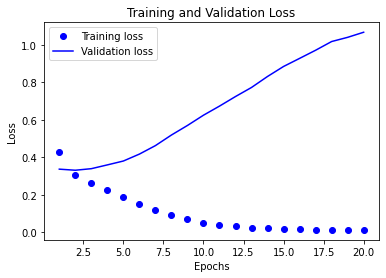

In [43]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

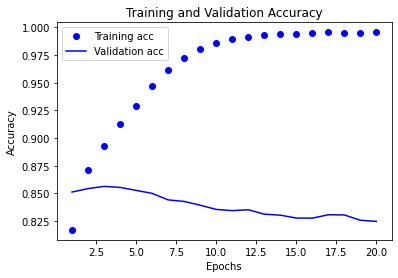

In [44]:
plt.clf()

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Embedding

In [45]:
embedding_simple = simple.layers[0]
weights = embedding_simple.get_weights()[0]

In [46]:
word2vec_file_path =os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [47]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-1.07075907e-01,  8.55837017e-03, -6.57212511e-02,  1.44962713e-01,
        2.61581801e-02, -1.30292803e-01, -1.84644207e-01, -1.02757895e-02,
        4.65097018e-02, -7.96555877e-02, -2.44447365e-01,  2.95203328e-01,
        2.18771040e-01,  9.44310217e-04, -1.00030944e-01,  5.44784442e-02,
        1.69689566e-01, -2.08537325e-01,  4.15393263e-02, -2.41145983e-01,
        1.21776149e-01,  1.30095975e-02,  2.94518545e-02, -3.22220385e-01,
        1.80398524e-01, -1.80501528e-02, -4.87469556e-03,  1.74697489e-01,
        9.02976282e-03, -1.16273798e-01,  7.37747923e-02, -1.82483763e-01,
        9.02751535e-02, -1.01213455e-01,  1.20399315e-02, -3.03892400e-02,
        1.04421988e-01,  1.39918393e-02, -5.18741310e-02,  1.02240346e-01,
       -5.98986149e-02, -3.81109007e-02,  2.23244786e-01,  1.87385031e-05,
       -3.09748501e-02, -3.23720068e-01,  1.45075303e-02,  1.18393771e-01,
        2.53711730e-01, -7.37274764e-03, -1.14093743e-01, -1.71013847e-01,
        2.02154070e-01,  

In [48]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word('love')

[('고마워요', 0.8968068957328796),
 ('습니당', 0.8751513957977295),
 ('새록새록', 0.8725975751876831),
 ('슬퍼요', 0.8672952055931091),
 ('we', 0.8613718748092651),
 ('♥♥', 0.8603352904319763),
 ('스며드', 0.8551819324493408),
 ('조음', 0.8515118956565857),
 ('life', 0.8378891944885254),
 ('밋기', 0.8347744941711426)]

한국어 Word2Vec

In [49]:
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [50]:
vocab_size = 10000    
word_vector_dim = 100  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [51]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer = Constant(embedding_matrix), 
                                    input_length = maxlen, 
                                    trainable = True))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation = 'relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [52]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs= epochs,
                    batch_size= 256,
                    validation_data= (X_val, y_val),
                    verbose= 1)

Epoch 1/20
532/532 [==============================] - 3s 5ms/step - loss: 0.5787 - accuracy: 0.6748 - val_loss: 0.4540 - val_accuracy: 0.7880
Epoch 2/20
532/532 [==============================] - 2s 4ms/step - loss: 0.4090 - accuracy: 0.8148 - val_loss: 0.3855 - val_accuracy: 0.8264
Epoch 3/20
532/532 [==============================] - 2s 4ms/step - loss: 0.3534 - accuracy: 0.8456 - val_loss: 0.3573 - val_accuracy: 0.8407
Epoch 4/20
532/532 [==============================] - 2s 4ms/step - loss: 0.3216 - accuracy: 0.8622 - val_loss: 0.3504 - val_accuracy: 0.8415
Epoch 5/20
532/532 [==============================] - 2s 4ms/step - loss: 0.2993 - accuracy: 0.8750 - val_loss: 0.3453 - val_accuracy: 0.8469
Epoch 6/20
532/532 [==============================] - 2s 5ms/step - loss: 0.2819 - accuracy: 0.8833 - val_loss: 0.3459 - val_accuracy: 0.8459
Epoch 7/20
532/532 [==============================] - 2s 5ms/step - loss: 0.2656 - accuracy: 0.8912 - val_loss: 0.3556 - val_accuracy: 0.8466
Epoch 

In [54]:
results = model.evaluate(X_test, y_test, verbose = 2)
print(results)

1537/1537 - 3s - loss: 0.5576 - accuracy: 0.8339
[0.5575501918792725, 0.8338792324066162]


# Result

RNN_Accuracy: 0.8397

Word2Vec_RNN_Accuracy: 0.8329

CNN_Accuracy: 0.8297

Word2Vec_CNN_Accuracy: 0.8340

Simple_Accuracy: 0.8221

Word2Vec_Simple_Accuracy: 0.8339